<div style="text-align:center;
            background-color: #ECBCFD;
            padding: 2rem 1rem;
            border: 3px solid #E2AFFF;
            border-radius: 5px;
            color: white;">
    <div style="margin:0;padding:0;font-size: 4rem;">🔥️ Pytorch | 🐱️ vs 🐶️ vs 🐼️</div>
    <a style="text-decoration: underline;color:#c287e8;font-size:2rem;" href="https://kaggle.com/shreydan">@shreydan</a>

In [43]:
# imports

import numpy as np
import pandas as pd 
from pathlib import Path

from collections import Counter

from sklearn.model_selection import train_test_split

from PIL import Image


import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import (Compose,
                                    RandomResizedCrop, 
                                    Resize,
                                    CenterCrop,
                                    RandomHorizontalFlip, 
                                    RandomVerticalFlip, 
                                    RandomPerspective, 
                                    RandomRotation,
                                    ColorJitter,
                                    Normalize,
                                    ToTensor
                                   )

import torchmetrics


import gc

# **Preparing Data**

In [44]:
paths = []
labels = []
import os
        
ds_path = '../input/animal-image-datasetdog-cat-and-panda/animals/'
for category in ['cats','dogs','panda']:
    for p in os.listdir(os.path.join(ds_path, category)):
        f = Path(os.path.join(ds_path,category, p))
        paths.append(f)
        labels.append(f.parent.stem)

In [45]:
Counter(labels)

Counter({'cats': 1000, 'dogs': 1000, 'panda': 1000})

In [46]:
# variation in image sizes

sizes = []
for path in paths:
    im = Image.open(path)
    sizes.append(im.size)
    im.close()
    
print(max(sizes), min(sizes))

(1600, 1200) (55, 75)


In [47]:
x_train, x_test, y_train, y_test = train_test_split(paths, labels, test_size=0.2, random_state=1357)

## Augmentations

In [48]:
basic_augmentations = Compose([
    Resize(224),
    CenterCrop(224),
    ToTensor()
])

basic_augmentations2 = Compose([
    RandomResizedCrop(224),
    ToTensor()
])

In [49]:
train_augmentations = Compose([
#     RandomResizedCrop(224),
    RandomHorizontalFlip(1),
    RandomVerticalFlip(0.1),
    RandomPerspective(distortion_scale=0.2, p=0.2),
    RandomRotation(30),
    ColorJitter(0.1,0.1,0.1),
    Resize(224),
    CenterCrop(224),
    ToTensor(),
#     Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#     Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
val_augmentations = train_augmentations

In [50]:
class AnimalDataset:
    
    def __init__(self, paths, labels, augmentations):
        self.paths = paths
        self.labels = labels
        self.classes = {
            'panda': 0,
            'dog': 1,
            'cat': 2
        }
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        
        sample = Image.open(self.paths[idx]).convert(mode="RGB")
        sample = self.augmentations(sample)
        
        label = self.labels[idx]
        if label == 'panda':
            label = 0
        elif label == 'dogs':
            label = 1
        elif label == 'cats':
            label = 2
        
        return (sample, torch.tensor(label, dtype=torch.long))

In [51]:
train_ds = AnimalDataset(x_train, y_train, train_augmentations)
val_ds = AnimalDataset(x_test, y_test, val_augmentations)

# **Visualization**

In [52]:
plot_ds = AnimalDataset(x_train[:16], y_train[:16], basic_augmentations)

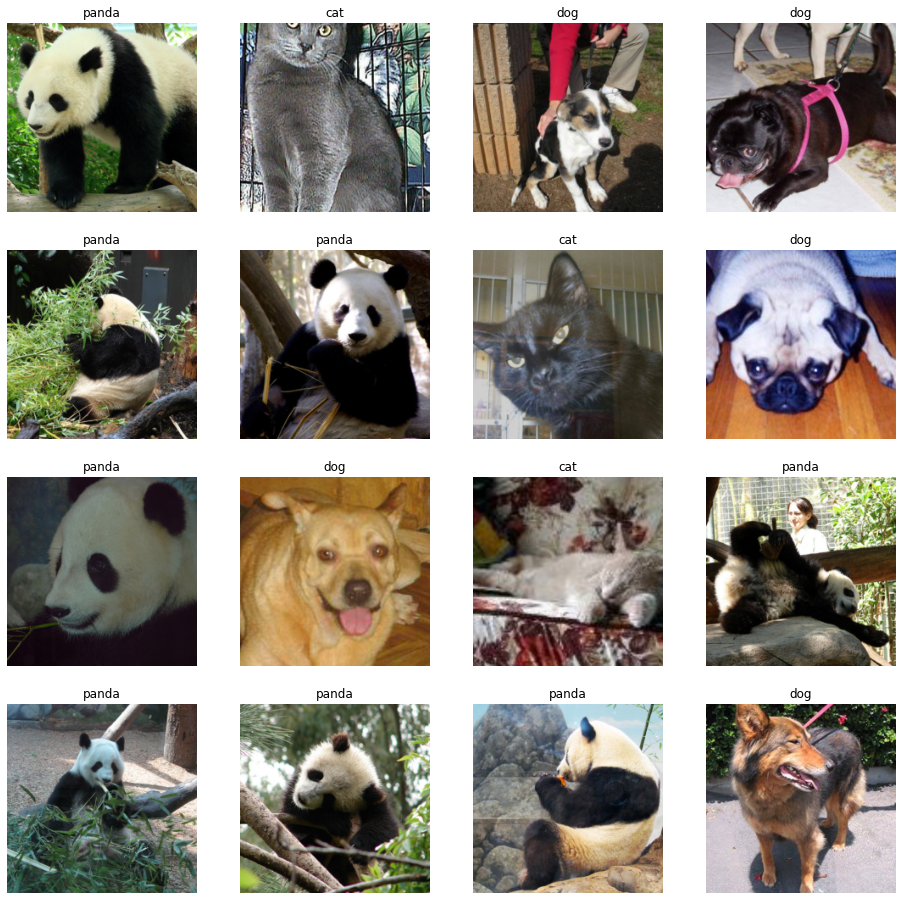

In [53]:
to_plot = []
classes = { 0: 'panda',
            1: 'dog',
            2: 'cat'
          }
for x,y in plot_ds:
    to_plot.append((x,y))
    
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(16,16))
for i in range(1,17):
    img = to_plot[i-1][0].permute(1,2,0)
    label = classes[(to_plot[i-1][1]).item()]
    figure.add_subplot(4,4,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

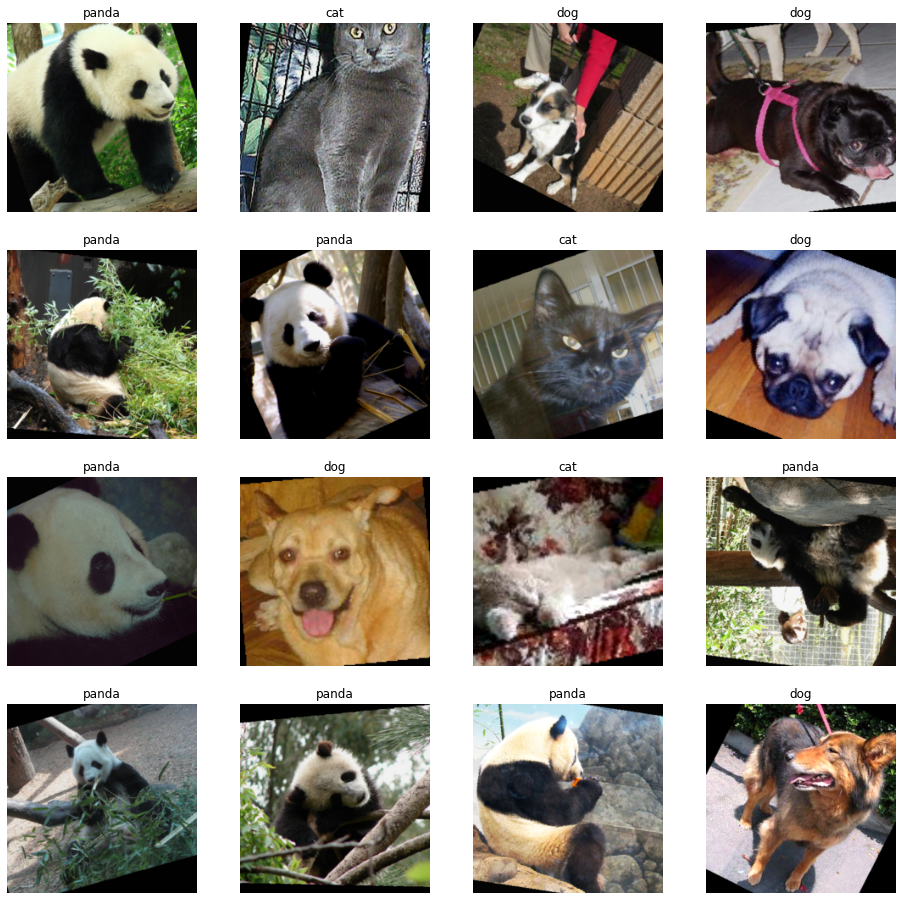

In [54]:
plot_ds_augmented = [train_ds[i] for i in range(16)]

figure = plt.figure(figsize=(16,16))
for i in range(1,17):
    img = plot_ds_augmented[i-1][0].permute(1,2,0)
    label = classes[(to_plot[i-1][1]).item()]
    figure.add_subplot(4,4,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

## Dataloaders

In [55]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, num_workers=2, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64, num_workers=2, shuffle=True)

In [56]:
len(train_loader), len(val_loader)

(38, 10)

# **Model 1** 

`Conv -> MaxPool -> Conv -> MaxPool -> Conv -> MaxPool -> Conv -> MaxPool -> Conv -> MaxPool`


In [57]:
class CNNModel(nn.Module):
    
    def __init__(self, in_features=3, num_classes=3):
        self.in_features = in_features
        self.num_classes = num_classes
        
        super(CNNModel, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(self.in_features,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64,128,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128,256,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(256,256,3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.linear_block = nn.Sequential(
            nn.Linear(256*5*5, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,self.num_classes)
        )

    def forward(self,x):
        x = self.conv_block(x)
        x = torch.flatten(x,1)
        x = self.linear_block(x)
        return x

In [58]:
print(CNNModel())

CNNModel(
  (conv_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=6400, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# **Training**

In [60]:
class Trainer:
    
    def __init__(self, model, loaders, config):
        self.model = model
        self.train_loader, self.val_loader = loaders
        self.config = config
        
        self.loss_fn = nn.CrossEntropyLoss()
        self.optim1 = torch.optim.SGD(self.model.parameters(), 
                                     lr=self.config['lr'], 
                                     momentum=self.config['sgd_momentum']
                                    )
        self.optim2 = torch.optim.Adam(self.model.parameters(),
                                       lr = self.config['lr']
                                      )
        
        
        self.optim = self.optim2
        
        if self.config['scheduler']:
            self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optim,step_size=2, gamma=0.2)
        
        self.metrics = torchmetrics.MetricCollection([
            torchmetrics.Accuracy(average='macro', num_classes=3),
            torchmetrics.Precision(average='macro', num_classes=3),
            torchmetrics.Recall(average='macro', num_classes=3),
            torchmetrics.F1Score(average='macro', num_classes=3)
        ]).to(self.config['device'])
        self.train_metrics = self.metrics.clone(prefix='train_')
        self.val_metrics = self.metrics.clone(prefix='val_')
        
        self.train_logs = []
        self.val_logs = []
        
    def logger(self, epoch, metrics, loss, mode):
        
        metrics = {metric:metrics[metric].cpu().item() for metric in metrics}

        log = {
            f'epoch_{epoch}': {
                'loss': loss,
                'metrics': metrics
            }
        }
        if mode == 'train':
            self.train_logs.append(log)
        else:
            self.val_logs.append(log)
            
    def print_per_epoch(self, epoch):
        print(f"\n\n{'-'*30}EPOCH {epoch+1}/{self.config['epochs']}{'-'*30}")
        train_loss = self.train_logs[epoch][f'epoch_{epoch}']['loss']
        train_acc = self.train_logs[epoch][f'epoch_{epoch}']['metrics']['train_Accuracy']
        val_loss = self.val_logs[epoch][f'epoch_{epoch}']['loss']
        val_acc = self.val_logs[epoch][f'epoch_{epoch}']['metrics']['val_Accuracy']
        print(f"Train -> LOSS: {train_loss} | ACC: {train_acc}")
        print(f"Validation -> LOSS: {val_loss} | ACC: {val_acc}")
        
    def train_one_epoch(self, epoch):
        
        running_loss = 0
        
        for x,y in self.train_loader:
            
            self.optim.zero_grad()
        
            x = x.to(self.config['device'])
            y = y.to(self.config['device'])
            
            preds = self.model(x)
            
            loss = self.loss_fn(preds, y)
            running_loss += loss.item()
            loss.backward()
            self.optim.step()
            
            self.train_metrics(torch.argmax(preds, dim=1), y)
            
            del x,y,preds,loss
            
        if self.config['scheduler']:
            self.scheduler.step()
            
        metrics = self.train_metrics.compute()
        train_loss = running_loss / len(self.train_loader)
        
        self.logger(epoch,metrics,train_loss,'train')

        del metrics
        
    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        
        running_loss = 0
        
        for x,y in self.val_loader:
            
            x = x.to(self.config['device'])
            y = y.to(self.config['device'])
            
            preds = self.model(x)
            loss = self.loss_fn(preds, y)
            running_loss += loss.item()
            
            self.val_metrics(torch.argmax(preds, dim=1), y)
            
            del x,y,preds,loss
            
        metrics = self.val_metrics.compute()
        val_loss = running_loss / len(self.val_loader)
        self.logger(epoch,metrics,val_loss,'val')
        
        del metrics
        
    def clear(self):
        gc.collect()
        torch.cuda.empty_cache()
            
        
    def fit(self):
        
        for epoch in range(self.config['epochs']):
            
            self.model.train()
            self.train_one_epoch(epoch)
            
            self.clear()
            
            self.model.eval()
            self.valid_one_epoch(epoch)
            
            self.clear()
            
            # reset metrics
            self.train_metrics.reset()
            self.val_metrics.reset()
            
            # print metrics
            self.print_per_epoch(epoch)
            
    

In [61]:
gc.collect()
torch.cuda.empty_cache()

# **Trainer with scheduler**

In [62]:
config = {
    'lr': 1e-3,
    'epochs': 10,
    'sgd_momentum': 0.8,
    'scheduler': True,
    'sch_step_size': 2,
    'sch_gamma': 0.2,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}
print(config['device'])
model = CNNModel().to(device=config['device'])
trainer = Trainer(model, (train_loader, val_loader), config)

cuda


In [63]:
trainer.fit()



------------------------------EPOCH 1/10------------------------------
Train -> LOSS: 1.098981383599733 | ACC: 0.3272618055343628
Validation -> LOSS: 1.0980487585067749 | ACC: 0.3333333432674408


------------------------------EPOCH 2/10------------------------------
Train -> LOSS: 1.039693584567622 | ACC: 0.42759186029434204
Validation -> LOSS: 0.9427611768245697 | ACC: 0.5072687268257141


------------------------------EPOCH 3/10------------------------------
Train -> LOSS: 0.8879301218610061 | ACC: 0.5409998297691345
Validation -> LOSS: 0.9165004909038543 | ACC: 0.5005896091461182


------------------------------EPOCH 4/10------------------------------
Train -> LOSS: 0.8364575222918862 | ACC: 0.5734791159629822
Validation -> LOSS: 0.8718802988529205 | ACC: 0.5659841299057007


------------------------------EPOCH 5/10------------------------------
Train -> LOSS: 0.8080943932658747 | ACC: 0.577660322189331
Validation -> LOSS: 0.8414001941680909 | ACC: 0.5724050998687744


----------

In [64]:
trainer.train_logs

[{'epoch_0': {'loss': 1.098981383599733,
   'metrics': {'train_Accuracy': 0.3272618055343628,
    'train_Precision': 0.32648029923439026,
    'train_Recall': 0.3272618055343628,
    'train_F1Score': 0.3130037784576416}}},
 {'epoch_1': {'loss': 1.039693584567622,
   'metrics': {'train_Accuracy': 0.42759186029434204,
    'train_Precision': 0.41662949323654175,
    'train_Recall': 0.42759186029434204,
    'train_F1Score': 0.41176068782806396}}},
 {'epoch_2': {'loss': 0.8879301218610061,
   'metrics': {'train_Accuracy': 0.5409998297691345,
    'train_Precision': 0.5280637741088867,
    'train_Recall': 0.5409998297691345,
    'train_F1Score': 0.5181808471679688}}},
 {'epoch_3': {'loss': 0.8364575222918862,
   'metrics': {'train_Accuracy': 0.5734791159629822,
    'train_Precision': 0.5614438056945801,
    'train_Recall': 0.5734791159629822,
    'train_F1Score': 0.5642610788345337}}},
 {'epoch_4': {'loss': 0.8080943932658747,
   'metrics': {'train_Accuracy': 0.577660322189331,
    'train_Prec

In [65]:
trainer.val_logs

[{'epoch_0': {'loss': 1.0980487585067749,
   'metrics': {'val_Accuracy': 0.3333333432674408,
    'val_Precision': 0.11444444954395294,
    'val_Recall': 0.3333333432674408,
    'val_F1Score': 0.17038874328136444}}},
 {'epoch_1': {'loss': 0.9427611768245697,
   'metrics': {'val_Accuracy': 0.5072687268257141,
    'val_Precision': 0.46603983640670776,
    'val_Recall': 0.5072687268257141,
    'val_F1Score': 0.44886863231658936}}},
 {'epoch_2': {'loss': 0.9165004909038543,
   'metrics': {'val_Accuracy': 0.5005896091461182,
    'val_Precision': 0.46979978680610657,
    'val_Recall': 0.5005896091461182,
    'val_F1Score': 0.454908162355423}}},
 {'epoch_3': {'loss': 0.8718802988529205,
   'metrics': {'val_Accuracy': 0.5659841299057007,
    'val_Precision': 0.5517399311065674,
    'val_Recall': 0.5659841299057007,
    'val_F1Score': 0.538436233997345}}},
 {'epoch_4': {'loss': 0.8414001941680909,
   'metrics': {'val_Accuracy': 0.5724050998687744,
    'val_Precision': 0.5542319416999817,
    'va

# **PLOTS**

In [70]:
def get_metric(metrics, mode, metric):
    values = []
    for i in range(10):
        base = metrics[i][f'epoch_{i}']
        if metric == 'loss':
            value = base['loss']
        else:
            value = base['metrics'][f'{mode}_{metric}']
        values.append(value)
        
    return values

## Loss Plot

Text(0.5, 1.0, 'Loss')

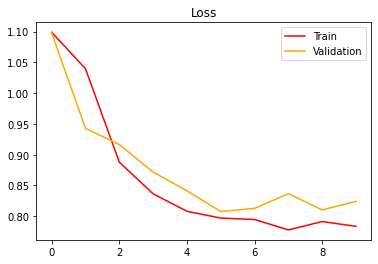

In [90]:
plt.plot(get_metric(trainer.train_logs,'train','loss'), color='red')
plt.plot(get_metric(trainer.val_logs,'val','loss'), color='orange')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.title('Loss')

## Accuracy Plot

Text(0.5, 1.0, 'Accuracy')

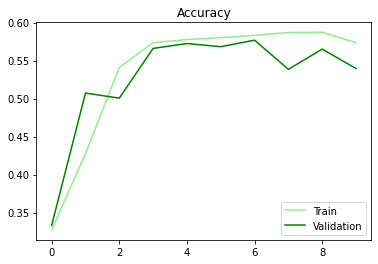

In [88]:
plt.plot(get_metric(trainer.train_logs,'train','Accuracy'), color='lightgreen')
plt.plot(get_metric(trainer.val_logs,'val','Accuracy'), color='green')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('Accuracy')

## Precision Plot

Text(0.5, 1.0, 'Precision')

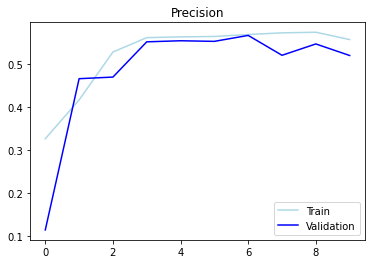

In [91]:
plt.plot(get_metric(trainer.train_logs,'train','Precision'), color='lightblue')
plt.plot(get_metric(trainer.val_logs,'val','Precision'), color='blue')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('Precision')

## Recall Plot

Text(0.5, 1.0, 'Recall')

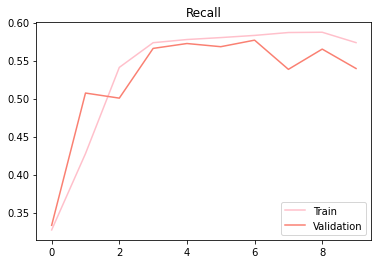

In [92]:
plt.plot(get_metric(trainer.train_logs,'train','Recall'), color='pink')
plt.plot(get_metric(trainer.val_logs,'val','Recall'), color='salmon')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('Recall')

## F1Score Plot

Text(0.5, 1.0, 'F1Score')

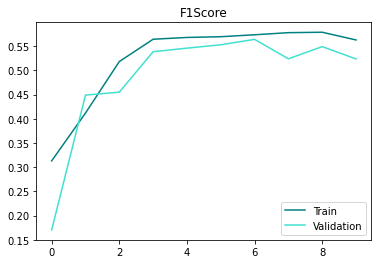

In [93]:
plt.plot(get_metric(trainer.train_logs,'train','F1Score'), color='teal')
plt.plot(get_metric(trainer.val_logs,'val','F1Score'), color='turquoise')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.title('F1Score')

# ✨️ Thoughts: ✨️

- Pytorch is fun, painful with regards to all the boilerplate training code but I am learning a lot while I write each step.
- Torchvision is pretty amazing, got to play around many [augmentations](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms) again for this project --- and one augmentation I've to read more on is `Normalize` {do I need to calculate it or used generic values I find on random tutorials}.
- Schedulers: adjust learning rate based on the no. of epochs. Here I used StepLR: Decays the learning rate of each parameter group by gamma every step_size epochs. [via pytorch docs](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
- Torchmetrics has been incredible, I was always scared to implement metrics on my own so sticked only to accuracy, but with torchmetrics everything has been smooth and +1 for the amazing docs!!!
- Adjusting the layers in the model was quite challenging...Initially had 4 [CONV+MAXPOOL] blocks and then changed it to 5 with the final block having same no. of in and out channels.
- CNNs are difficult to train, I even tried my own [implementation of VGG16 (untrained)](https://github.com/shreydan/pytorch-CNN-image-models/blob/main/VGGNet16.ipynb) and added few more fully-connected layers to reduce outputs from 1000 to 3 but it performed worse than the 4 blocks version.

- The next thing I want to do is either train more models I code on random kaggle datasets or learn about `transfer-learning`. Definitely something I want to try out.
- More stuff I want to try: Saving models, early stopping
- Shift to something which has less boilerplate code. Libraries that come to my mind are Pytorch-Lightning and [Tez](https://github.com/abhishekkrthakur/tez), Tez being under development, gonna try out Lightning first.
- Look at ways to improve model performance --- hyper-parameter tuning, k-fold cross-validation.
- Learn using Tensorflow for some projects -- I went with Pytorch since I wanted to know more about each step that goes into training, Tensorflow has lot of abstraction (I think so).

> Thank you for checking out this notebook, feel free to upvote and comment your thoughts, would love some suggestions and lemme know if I made any mistakes I overlooked anywhere. :)

✨️✨️✨️